In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import randint

#Everything before "image = plt.imread(image)" is just on ellas request, before we actually submit it would be replaced
choice = input("Tall (T) or Wide (W)")
while choice.upper() != "T" and choice.upper() != "W":
    choice = input("Tall (T) or Wide (W)")
if choice.upper() == "T":
    ella_hugo_BOSS_ulbrich = randint(1,22)
    if ella_hugo_BOSS_ulbrich == 7:
        image = "Tall2.jpg"
        #Thales: 80 wide, 134 high
    else:
        image = "Tall1.jpg"
        #Ella: 80 wide, 155 high
else:
    image = "aWide.jpg"
    #164 wide, 80 high

image = plt.imread(image)
size = max(image.shape[0],image.shape[1])*4
canvas = np.zeros((size, int(size*1.5), image.shape[2]), dtype=np.uint8)
canvas += 255
f = int(4*image.shape[1])
start_x = int(1.20*image.shape[1])
start_y = int(-0.5*image.shape[0])
for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        colour = image[y, x]
        old_x = x + start_x
        old_y = y + start_y
        new_x = int(-(f*old_x) / (old_x-f))
        new_y = int((old_y/old_x)*new_x)
        try:
            canvas[(size//2)+old_y, (3*size//4)+old_x] = colour
        except:
            continue
        for dy in range(-1, 2):
            for dx in range(-1, 2):
                try:
                    canvas[(size//2)+new_y+dy, (3*size//4)+new_x+dx] = colour
                except:
                    continue

plt.imshow(canvas, extent=[-size*1.5, size*1.5, -size, size])
plt.xlim(-size*1.5, size*1.5)
plt.ylim(-size, size)
plt.axvline(x=0)
plt.scatter(f, 0, color='red', marker='*')
plt.scatter(-f, 0, color='red', marker='*')

Tall (T) or Wide (W)T


FileNotFoundError: [Errno 2] No such file or directory: 'Tall1.jpg'

Tall (T) or Wide (W):  T


Total processing time: 0.06642909999936819


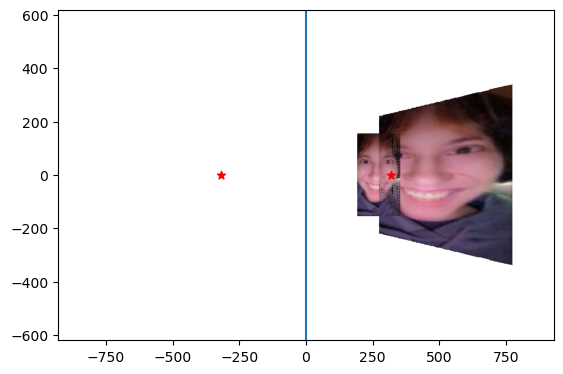

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from random import randint
from time import perf_counter

# === Image Selection (untimed) ===
choice = input("Tall (T) or Wide (W): ")
while choice.upper() not in ("T", "W"):
    choice = input("Tall (T) or Wide (W): ")

if choice.upper() == "T":
    if randint(1, 22) == 7:
        image_file = "Tall2.jpg"  # Thales: 80 wide, 134 high
    else:
        image_file = "Tall1.jpg"  # Ella: 80 wide, 155 high
else:
    image_file = "aWide.jpg"      # 164 wide, 80 high

image = plt.imread(image_file)

# ---- Start timing AFTER user input ----
start_time = perf_counter()

# === Setup and Precalculations ===
# For this task, the image is within the focal length so the object and the virtual image
# are on the same side and may overlap. We must be careful to restrict interpolation to the new image’s region.
size = max(image.shape[0], image.shape[1]) * 4
canvas_height = size
canvas_width = int(size * 1.5)
canvas = np.full((canvas_height, canvas_width, image.shape[2]), 255, dtype=np.uint8)

# Define parameters (values are as in your bad code)
f = int(4 * image.shape[1])
start_x = int(1.20 * image.shape[1])
start_y = int(-0.5 * image.shape[0])

# Offsets into the canvas remain as in your original code.
offset_y = canvas_height // 2
offset_x = 3 * canvas_height // 4

# === Vectorized Coordinate Transformation ===
img_height, img_width, channels = image.shape

# Create a grid of pixel indices for the source image
yy, xx = np.indices((img_height, img_width))

# Object coordinates (the “old” placement): simply shift the image.
old_x = xx + start_x
old_y = yy + start_y

# Virtual image coordinates (via the converging lens formula):
# new_x = - (f * old_x) / (old_x - f)
# new_y = (old_y / old_x) * new_x
new_x_float = - (f * old_x) / (old_x - f)
new_x = new_x_float.astype(int)
new_y_float = (old_y / old_x) * new_x_float
new_y = new_y_float.astype(int)

# Compute canvas indices for both object (old) and virtual image (new)
old_canvas_y = offset_y + old_y
old_canvas_x = offset_x + old_x

new_canvas_y = offset_y + new_y
new_canvas_x = offset_x + new_x

# === Assign Pixels to Canvas with Validity Checks ===
# For the object (old) image:
valid_old = (old_canvas_y >= 0) & (old_canvas_y < canvas_height) & \
            (old_canvas_x >= 0) & (old_canvas_x < canvas_width)
canvas[old_canvas_y[valid_old], old_canvas_x[valid_old]] = image[yy[valid_old], xx[valid_old]]

# For the virtual (new) image:
valid_new = (new_canvas_y >= 0) & (new_canvas_y < canvas_height) & \
            (new_canvas_x >= 0) & (new_canvas_x < canvas_width)
canvas[new_canvas_y[valid_new], new_canvas_x[valid_new]] = image[yy[valid_new], xx[valid_new]]

# === Compute Bounding Box for the Virtual Image Only ===
# This bounding box will be used to restrict the region for interpolation.
# (Even if parts of the object image overlap, we do not include those cells.)
all_new_x = new_canvas_x[valid_new].ravel()
all_new_y = new_canvas_y[valid_new].ravel()

raw_min_x = int(all_new_x.min())
raw_max_x = int(all_new_x.max())
raw_min_y = int(all_new_y.min())
raw_max_y = int(all_new_y.max())

# To avoid negative indexing when slicing the canvas, we clip to valid indices.
bb_left = max(raw_min_x, 0)
bb_right = min(raw_max_x, canvas_width - 1)
bb_top = max(raw_min_y, 0)
bb_bottom = min(raw_max_y, canvas_height - 1)

# === Interpolation: Restrict Only to the Virtual Image’s Bounding Box ===
# We define two helper functions (one for rows and one for columns) which will interpolate
# between the first and last non-white pixels within that bounding box, preserving cells outside.
def fix_row(row, left, right):
    """
    For a given row (within the bounding box for the new image), interpolate between
    the non-white pixels. Only the segment between the first and last non-white cell is modified.
    """
    cols = np.arange(left, right + 1)
    # Extract the current row segment from the canvas
    row_slice = canvas[row, left:right+1]  # shape (width, channels)
    # Mark pixels that are not pure white; note that a pixel is considered non-white if any channel != 255.
    mask = (row_slice != 255).any(axis=1)
    if mask.sum() < 2:
        return
    filled_cols = cols[mask]
    seg_left = filled_cols[0]
    seg_right = filled_cols[-1]
    # Interpolate across only the contiguous segment between the first and last non-white pixels.
    interp_cols = np.arange(seg_left, seg_right + 1)
    for ch in range(channels):
        xp = filled_cols
        fp = row_slice[mask, ch]
        interpolated = np.interp(interp_cols, xp, fp)
        canvas[row, interp_cols, ch] = np.around(interpolated).astype(np.uint8)

def fix_col(col, top, bottom):
    """
    For a given column (within the bounding box for the new image), interpolate between
    the non-white pixels. Only the segment between the first and last non-white cell is modified.
    """
    rows = np.arange(top, bottom + 1)
    col_slice = canvas[top:bottom+1, col]  # shape: (height, channels)
    mask = (col_slice != 255).any(axis=1)
    if mask.sum() < 2:
        return
    filled_rows = rows[mask]
    seg_top = filled_rows[0]
    seg_bottom = filled_rows[-1]
    interp_rows = np.arange(seg_top, seg_bottom + 1)
    for ch in range(channels):
        xp = filled_rows
        fp = col_slice[mask, ch]
        interpolated = np.interp(interp_rows, xp, fp)
        canvas[interp_rows, col, ch] = np.around(interpolated).astype(np.uint8)

# Apply interpolation first along columns, then along rows within the bounding box of the new image.
for col in range(bb_left, bb_right + 1):
    fix_col(col, bb_top, bb_bottom)
for row in range(bb_top, bb_bottom + 1):
    fix_row(row, bb_left, bb_right)

print("Total processing time:", perf_counter() - start_time)

# === Plot the Result ===
plt.imshow(canvas, extent=[-size * 1.5, size * 1.5, -size, size])
plt.xlim(-size * 1.5, size * 1.5)
plt.ylim(-size, size)
plt.axvline(x=0)
plt.scatter(f, 0, color='red', marker='*')
plt.scatter(-f, 0, color='red', marker='*')
plt.show()